In [1]:
import numpy as np
import tensorflow as tf
import gym
from gym import spaces
import copy

from stable_baselines.common.policies import *
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import *

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from celluloid import Camera

In [3]:
assert tf.version.VERSION[0] == '1'

## Area

In [4]:
class Area:
    def __init__(self, size=20, threshold=0.6, border_width=2, border_val=-3):
        self.size = size
        self.threshold = threshold
        self.border_width = border_width
        self.border_val = border_val
        self.area = self.__generate_area()
    
    def reset(self):
        self.area = self.__generate_area()
    
    def __generate_area(self):
        border_row = np.array([[self.border_val for i in range(self.size + 2*self.border_width)]])
        border = np.repeat(border_row, self.border_width, axis=0)
        init_area = border

        for i in range(self.size):
            row = (np.random.rand(self.size) > self.threshold).astype(int) * 3
            for i in range(self.border_width):
                row = np.insert(row, 0, self.border_val)
                row = np.append(row, self.border_val)
            init_area = np.concatenate((init_area, [row]))

        init_area = np.concatenate((init_area, border))

        return init_area

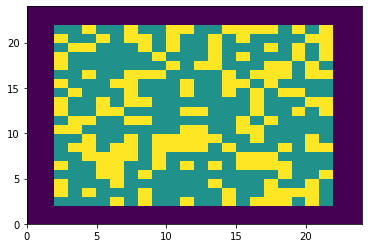

In [5]:
test_area = Area()

plt.pcolor(test_area.area)

## Agent

In [6]:
class Agent(gym.Env):
    
    def __init__(self, area):
        self.area = area
        self.reward_rangee = (0, 3)
        self.action_space = spaces.Discrete(6)
        self.observation_space = spaces.MultiDiscrete(nvec=[3 for i in range(25)])
        
    def reset(self, position=(10, 10), train=True):
        self.fitness = 10
        self.position = position
        self.reward_sum = 0
        if train:
            self.area.reset()
        
        return self._next_observation()
    
    def _next_observation(self):
        x, y = self.position
        visible = self.area.area[x-2:x+3, y-2:y+3]
        
        return visible.reshape(25)
    
    def step(self, action, test=False):
        
        reward = 0
        x, y = self.position
        
        if action < 4:
            if action == 0:
                new_y = y-1 if y>self.area.border_width else y
                self.position = x, new_y
            if action == 1: 
                new_y = y+1 if y<self.area.size + self.area.border_width - 1 else y
                self.position = x, new_y
            if action == 2:
                new_x = x+1 if x<self.area.size + self.area.border_width - 1 else x
                self.position = new_x, y
            if action == 3:
                new_x = x-1 if x>self.area.border_width else x
                self.position = new_x, y
            x, y = self.position
            self.fitness -= 1
        elif action == 4:
            if self.area.area[x, y] == 3:
                self.reward_sum += 6
                self.fitness += 6
                reward = 6
                self.area.area[x, y] = 0
            else:
                self.fitness -= 1
        else: 
            if self.fitness >= 16:
                self.reward_sum += 16
                self.fitness -= 5
                reward = 16
                if test:
                    # TODO
                    spawn_new(x, y)
            else:
                self.fitness -= 1
                
        
        done = self.fitness <= 0
        
        obs = self._next_observation()
        
        return obs, reward, done, {}
    
    def render(self, mode='human', close=False):
        x, y = self.position
        print(self.__hash__(), ":  ", self.reward_sum)
        return x, y

## Model

In [7]:
area = Area()
model = A2C(MlpPolicy, Agent(area), verbose=0)
model.learn(total_timesteps=30000)





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




## Simulation

In [8]:
area = Area()
env1 = Agent(area)
envs = [env1]
env_obs = {}

stored_maps = []

def spawn_new(x, y):
    new_env = Agent(area)
    obs = new_env.reset(position=(x, y), train=False)
    envs.append(new_env)
    env_obs[new_env] = obs

for env in envs:
    obs = env.reset(train=False)
    env_obs[env] = obs

for i in range(200):
    copied_map = np.copy(area.area)
    
    for idx, env in enumerate(envs):
        obs = env_obs[env]
        action, _states = model.predict(obs)
        obs, rewards, done, info = env.step(action, test=True)
        env_obs[env] = obs
        x, y = env.render()
        copied_map[x,y] = -2
        if done:
            envs.pop(idx)
        
    stored_maps.append(copied_map)

345888165 :   0
345888165 :   6
345888165 :   6
345888165 :   6
345888165 :   6
345888165 :   6
345888165 :   12
345888165 :   12
345888165 :   18
345888165 :   18
345888165 :   24
345888165 :   24
345888165 :   30
345888165 :   30
345888165 :   36
345888165 :   52
346477977 :   0
345888165 :   68
346477977 :   0
346477973 :   0
345888165 :   68
346477977 :   6
346477973 :   0
345888165 :   74
346477977 :   6
346477973 :   0
345888165 :   74
346477977 :   12
346477973 :   0
345888165 :   74
346477977 :   12
346477973 :   0
345888165 :   74
346477977 :   12
346477973 :   0
345888165 :   74
346477977 :   12
346477973 :   0
345888165 :   80
346477977 :   18
346477973 :   0
345888165 :   96
346477977 :   18
346477973 :   0
346478077 :   0
345888165 :   96
346477977 :   24
346477973 :   0
345888165 :   112
346477977 :   40
346478077 :   0
346483577 :   0
346483649 :   0
345888165 :   128
346477977 :   56
346478077 :   0
346483577 :   0
346483649 :   0
346483637 :   0
346483481 :   0
3458881

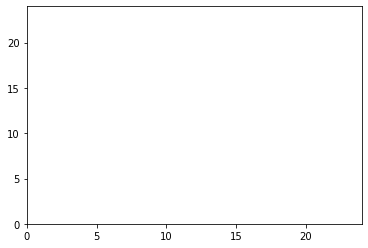

In [9]:
fig = plt.figure()
camera = Camera(fig)
for i in range(200):
    plt.pcolor(stored_maps[i])
    camera.snap()
animation = camera.animate()
animation.save('sim_final_8.gif', writer = 'imagemagick')